### Настройка окружения для google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd  drive/MyDrive/'Colab Notebooks'/Coloring-greyscale-images/Alpha-version/

/content/drive/MyDrive/Colab Notebooks/Coloring-greyscale-images/Alpha-version


In [ ]:
# !git pull origin alhpa-version

From https://github.com/Evgev/Coloring-greyscale-images
 * branch            alhpa-version -> FETCH_HEAD
Already up to date.


In [ ]:
!ls -ar Cats_lapkins/

In [ ]:
! unzip  ../datathon_comanda_AA-main.zip

In [ ]:
!git branch

* alhpa-version


### Альфа версия

#### Загрузка изображений

##### Загрузка изображений котиков

In [104]:
from image_processing import get_dataset

image_shape = (256, 256)
# images_array_RGB = get_dataset(path_to_images_folder = 'train_images', desired_size=(256, 256), max_samples = 1000)
images_array_RGB = get_dataset(path_to_images_folder = "Cats_lapkins", desired_size=image_shape, max_samples = 100)



Shape of images_array: (100, 256, 256, 3)
Data type of images_array: uint8


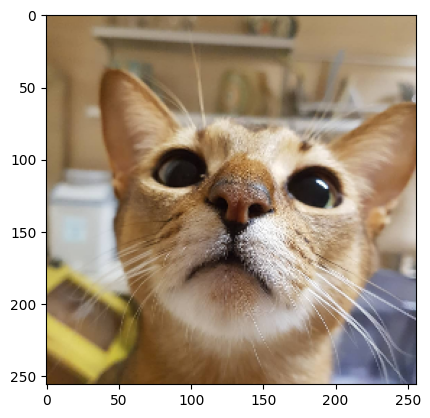

In [105]:
import matplotlib.pyplot as plt

plt.imshow(images_array_RGB[1])

#### Создание обучающей и тестовой выборок

In [106]:
from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import numpy as np

images_array_Lab = np.array([rgb2lab(image/255) for image in images_array_RGB])
# del images_array_RGB

x = images_array_Lab[:,:,:,0]
y = images_array_Lab[:,:,:,1:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
del images_array_Lab, x, y

x_train.shape, y_train.shape, x_train.dtype, y_train.dtype


((64, 256, 256), (64, 256, 256, 2), dtype('float64'), dtype('float64'))

#### Создание модели

In [5]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



2025-01-02 15:49:42.494019: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 15:49:44.412863: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 15:49:46.056912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735822186.332679    2057 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735822186.712483    2057 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 15:49:50.339447: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [107]:

# Building the neural network
model = Sequential()
model.add(InputLayer(input_shape=(*image_shape, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [39]:
# print(model.summary())

In [110]:
from tensorflow.keras import optimizers

import tensorflow as tf
def ssim_metric(y_true, y_pred):
    ssim_values = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(ssim_values)



model.compile(optimizer='rmsprop',loss='mae', metrics=[ssim_metric, 'mae'])

### Обучение модели

In [111]:
from tensorflow.keras.callbacks import TensorBoard
import os

# Создание каталога для логов
log_dir = os.path.join("logs")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [112]:
history = model.fit(x=np.expand_dims(x_train, axis = 3),
    y=y_train/128,
    batch_size=6,
    epochs=200,
    validation_data = (x_val, y_val/128),
    verbose = 1,
    callbacks=[tensorboard_callback]
    
)

Epoch 1/200


11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 575ms/step - loss: 0.1097 - mae: 0.1097 - ssim_metric: 0.1213 - val_loss: 0.0567 - val_mae: 0.0567 - val_ssim_metric: 0.2535
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - loss: 0.0584 - mae: 0.0584 - ssim_metric: 0.3356 - val_loss: 0.0660 - val_mae: 0.0660 - val_ssim_metric: 0.3205
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 477ms/step - loss: 0.0590 - mae: 0.0590 - ssim_metric: 0.3637 - val_loss: 0.0541 - val_mae: 0.0541 - val_ssim_metric: 0.3095
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 477ms/step - loss: 0.0512 - mae: 0.0512 - ssim_metric: 0.3931 - val_loss: 0.0566 - val_mae: 0.0566 - val_ssim_metric: 0.3305
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 512ms/step - loss: 0.0569 - mae: 0.0569 - ssim_metric: 0.3909 - val_loss: 0.0544 - val_mae: 0.0544 - val_ssim_metric: 0.3323
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 517ms/step - loss: 0.0606 - mae: 0.0606 - ssim_metric: 0.3649 - val_loss: 0.0539 - val_mae: 0.0539 - val_ssim_metric: 0.3250
Epoch 7/2

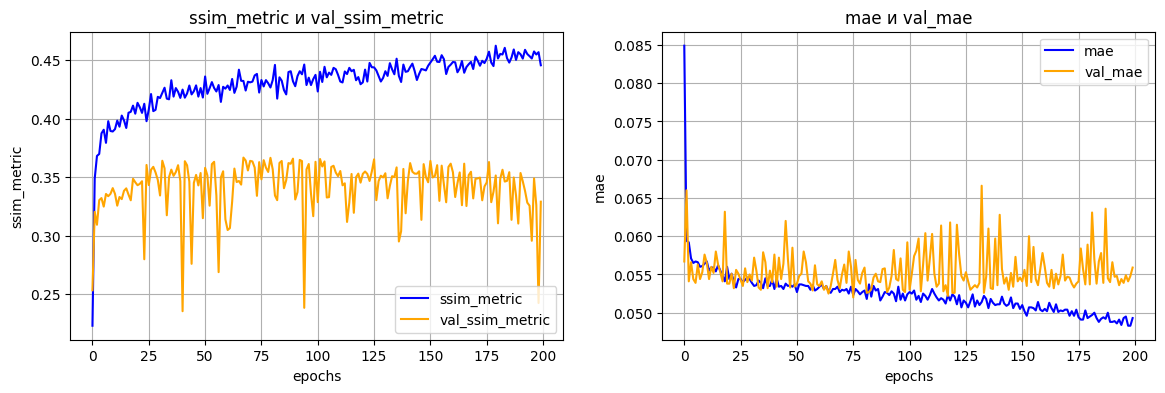

In [113]:
import matplotlib.pyplot as plt
import test_model as tm
import importlib as imp
imp.reload(tm)

tm.my_plot(history=history, metrics=["ssim_metric", "mae"], show_start_position=0, round_loss=4)

RMSprop log_cosh
{'loss_function': 'log_cosh', 'optimizer': 'RMSprop'}


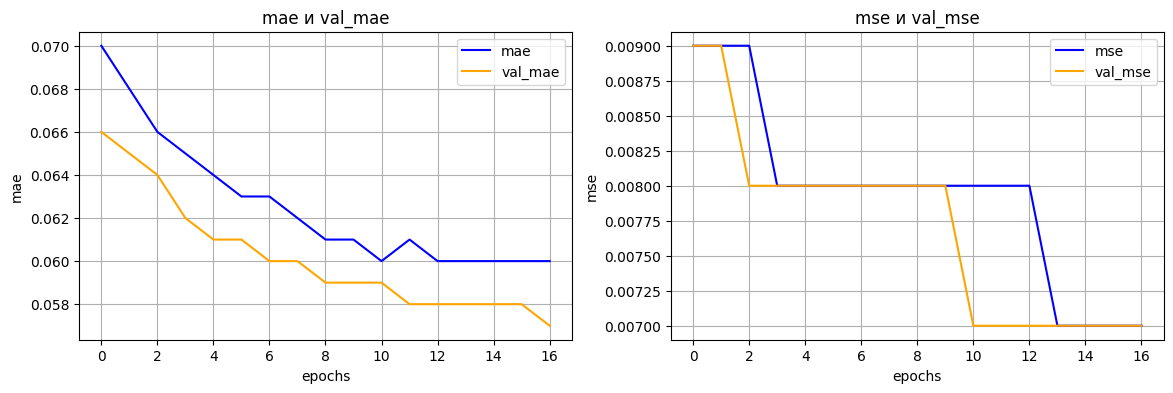

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 7.6858 - mae: 8.3197 - mse: 163.3976 
RMSprop tversky
{'loss_function': 'tversky', 'optimizer': 'RMSprop'}


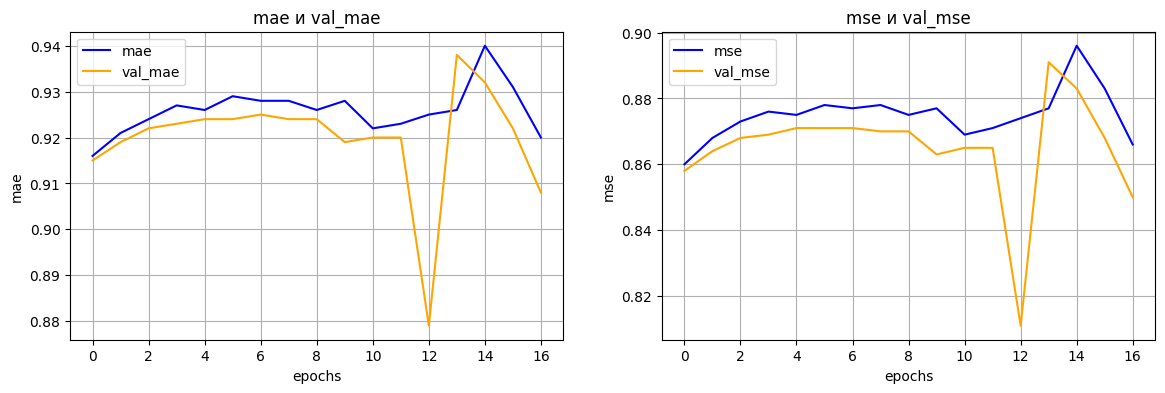

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: -0.6333 - mae: 7.9609 - mse: 154.5088 
RMSprop dice
{'loss_function': 'dice', 'optimizer': 'RMSprop'}


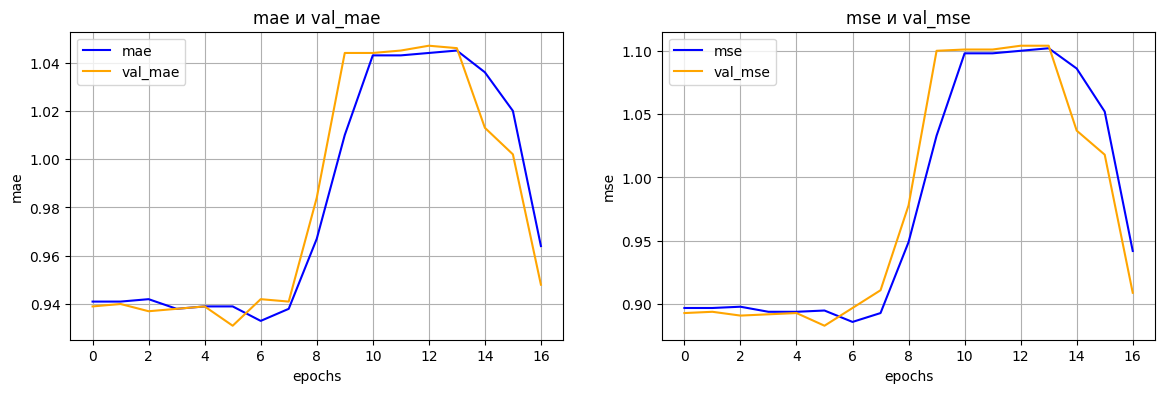

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: -0.5666 - mae: 7.9989 - mse: 155.1198 
RMSprop mean_squared_error
{'loss_function': 'mean_squared_error', 'optimizer': 'RMSprop'}


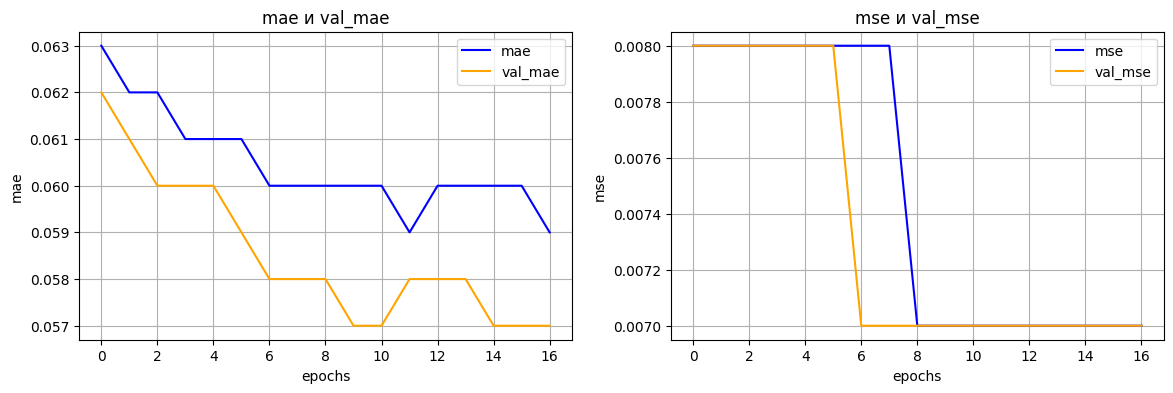

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 163.3803 - mae: 8.3191 - mse: 163.3803 
RMSprop mean_absolute_error
{'loss_function': 'mean_absolute_error', 'optimizer': 'RMSprop'}


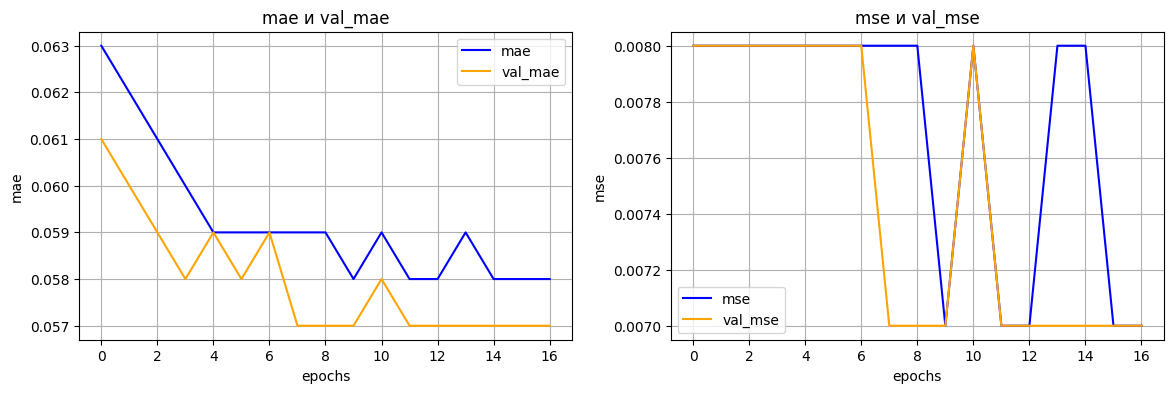

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 8.3272 - mae: 8.3272 - mse: 163.5972 
RMSprop mean_absolute_percentage_error
{'loss_function': 'mean_absolute_percentage_error', 'optimizer': 'RMSprop'}


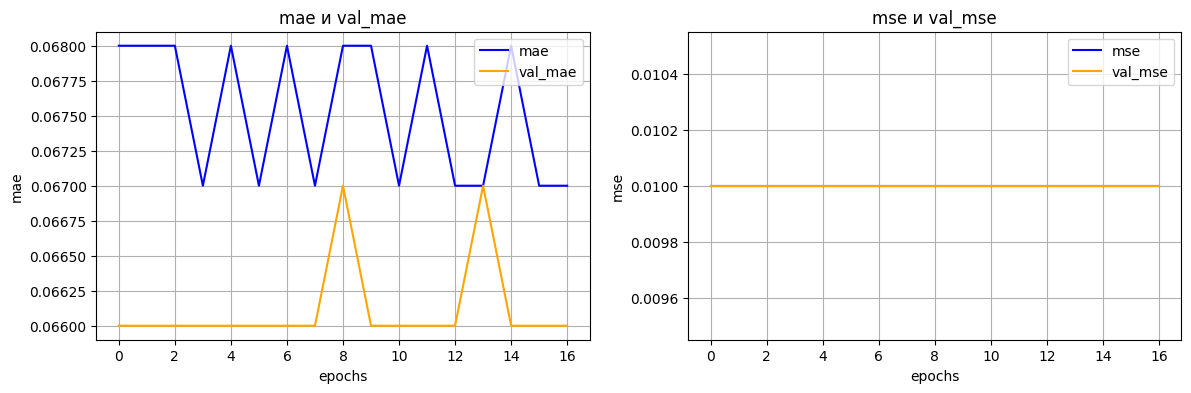

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 145.0433 - mae: 8.3410 - mse: 163.9969 
RMSprop mean_squared_logarithmic_error
{'loss_function': 'mean_squared_logarithmic_error', 'optimizer': 'RMSprop'}


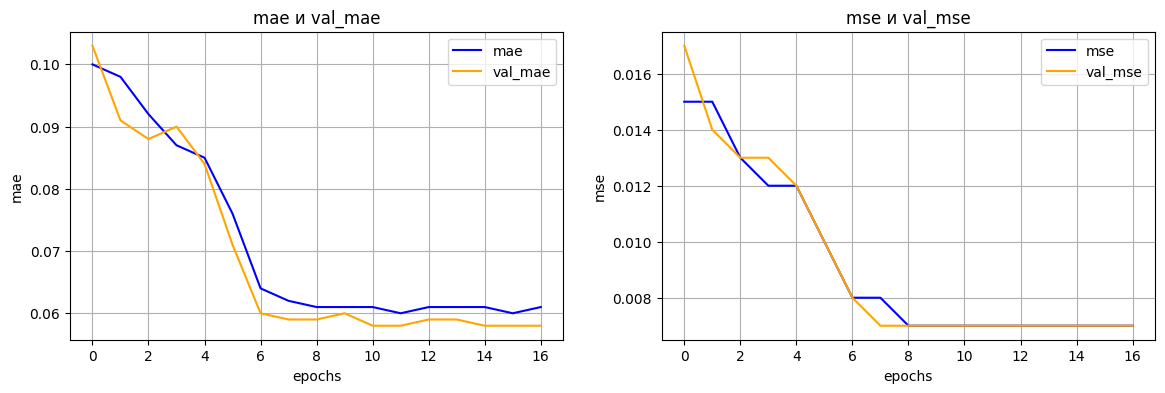

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 3.1894 - mae: 8.3165 - mse: 163.3228 
RMSprop cosine_similarity
{'loss_function': 'cosine_similarity', 'optimizer': 'RMSprop'}


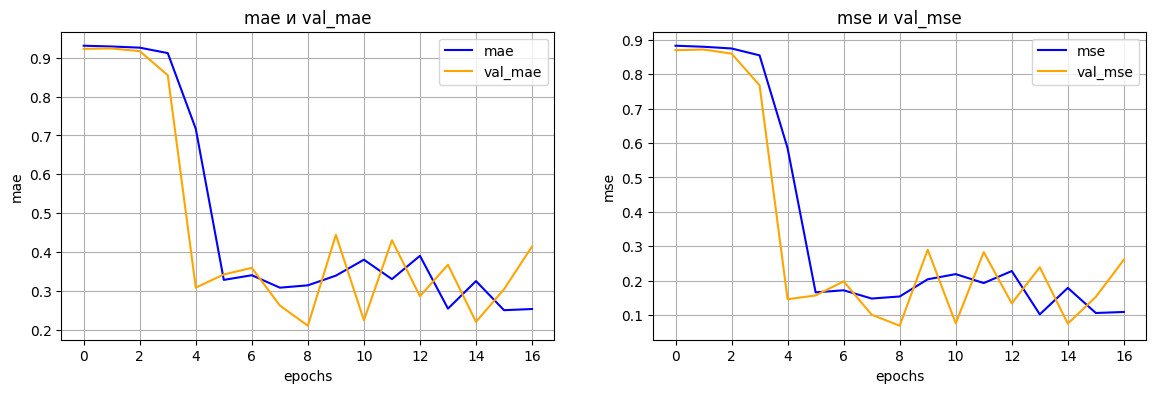

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: -0.4763 - mae: 8.1516 - mse: 158.2952 


In [106]:
import test_model as tm
import importlib as imp
imp.reload(tm)

# params=[
#   {"optimizer":"adam", "loss_function": "mean_absolute_error"}
#   ,{"optimizer":"adam", "loss_function": "cosine_similarity"}
#   ,{"optimizer":"SGD", "loss_function": "cosine_similarity"}
#   ,{"optimizer":"RMSprop", "loss_function": "mean_absolute_error"}
#   ,{"optimizer":"RMSprop", "loss_function": "cosine_similarity"}
#   ,{"optimizer":"SGD", "loss_function": "cosine_similarity"}
# ]
params=[
  # ,{"optimizer":"RMSprop", "loss_function": "huber_loss"}
  {"optimizer":"RMSprop", "loss_function": "log_cosh"}
  ,{"optimizer":"RMSprop", "loss_function": "tversky"}
  ,{"optimizer":"RMSprop", "loss_function": "dice"}
  ,{"optimizer":"RMSprop", "loss_function": "mean_squared_error"}
  ,{"optimizer":"RMSprop", "loss_function": "mean_absolute_error"}
  ,{"optimizer":"RMSprop", "loss_function": "mean_absolute_percentage_error"}
  ,{"optimizer":"RMSprop", "loss_function": "mean_squared_logarithmic_error"}
  ,{"optimizer":"RMSprop", "loss_function": "cosine_similarity"}
]

result_metrics, hist_df = tm.cdcoalf(model = model
                            ,params=params
                            ,data = [x_train, y_train, x_val, y_val, x_test, y_test]
                            ,metrics = ["mae", "mse"]
                            ,epochs = 20
                            ,show_start_position = 3
                            ,round_loss = 3
                            ,tensorboard_callback = tensorboard_callback)


In [70]:
result_metrics

optimizer                  loss_functions  \
0   RMSprop                        log_cosh   
1   RMSprop                         tversky   
2   RMSprop                            dice   
3   RMSprop              mean_squared_error   
4   RMSprop             mean_absolute_error   
5   RMSprop  mean_absolute_percentage_error   
6   RMSprop  mean_squared_logarithmic_error   
7   RMSprop               cosine_similarity   

                                            evaluate  \
0  [7.8744659423828125, 8.508976936340332, 171.01...   
1  [2.9875636100769043, 8.983442306518555, 181.63...   
2  [-0.5768415927886963, 8.161580085754395, 162.3...   
3  [170.965576171875, 8.508201599121094, 170.9655...   
4  [8.515645980834961, 8.515645980834961, 171.178...   
5  [281.6945495605469, 8.532316207885742, 171.669...   
6  [3.2381718158721924, 8.505403518676758, 170.92...   
7  [-0.4946081042289734, 8.476125717163086, 170.0...   

                                                loss  \
0  [0.11213712394237518, 0.00516836391761899, 0.0...   
1  [0.5161974430084229, 0.9339669942855835, 0.894...   
2  [0.4287201166152954, 0.8942733407020569, 0.894...   
3  [0.3165794909000397, 0.01681174524128437, 0.01...   
4  [0.2620752453804016, 0.06529614329338074, 0.06...   
5  [191004.3125, 20960.09765625, 7462.4912109375,...   
6  [0.01246101688593626, 0.007449772208929062, 0....   
7  [-0.2999459505081177, -0.5652380585670471, -0....   

                                            val_loss  
0  [0.005656400229781866, 0.004922136664390564, 0...  
1  [1.0238882303237915, 0.8914423584938049, 0.891...  
2  [0.8913588523864746, 0.8913487195968628, 0.891...  
3  [0.016731655225157738, 0.012140902690589428, 0...  
4  [0.0672808364033699, 0.06193331256508827, 0.05...  
5  [80287.03125, 25448.251953125, 12284.65625, 52...  
6  [0.007335252594202757, 0.007331325672566891, 0...  
7  [-0.5655984878540039, -0.5941606760025024, -0....

### Тестирование обученной модели

In [117]:
model.evaluate(x_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 3.1795 - mae: 8.3148 - mse: 163.2750 


[3.2361061573028564, 8.505232810974121, 170.91952514648438]

In [77]:
def lab_in_rgb(x, y):
  cur = np.zeros((*x.shape, 3))
  cur[:,:,0] = x
  cur[:,:,1:] = y
  cur_rgb = (lab2rgb(cur) * 255).astype(np.uint8)
  return cur_rgb

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


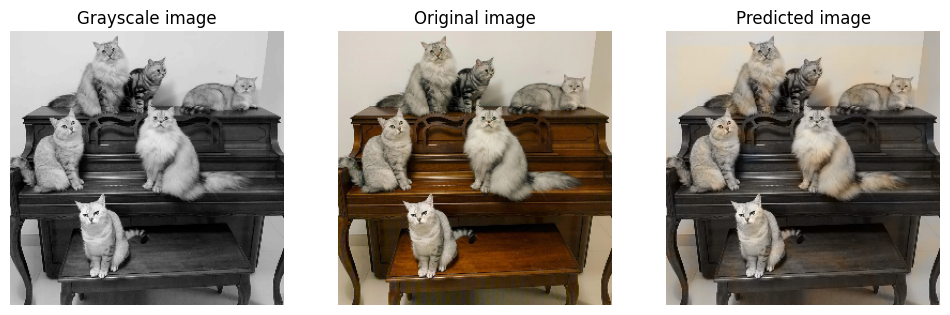

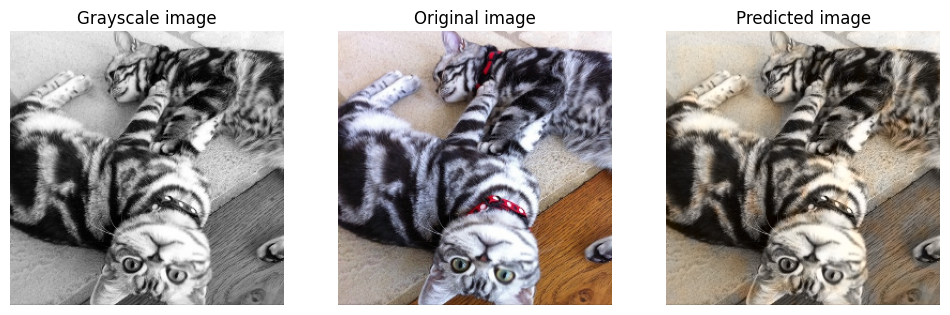

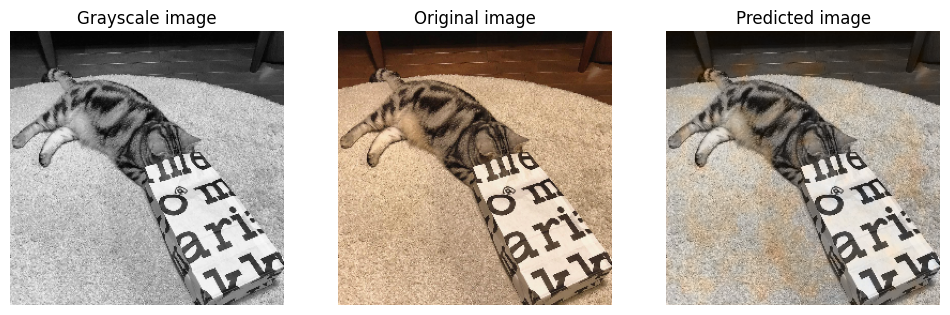

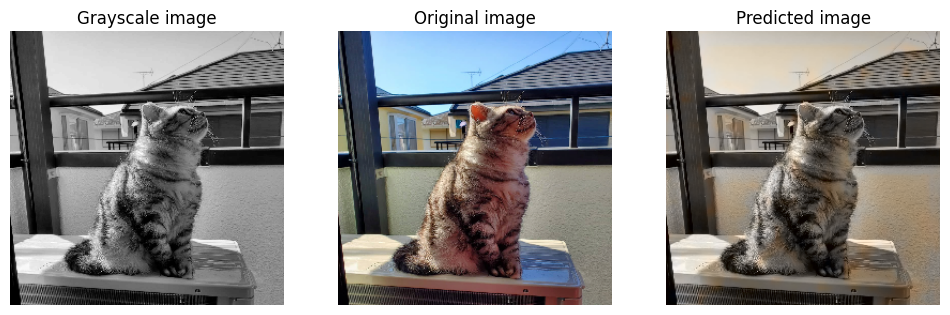

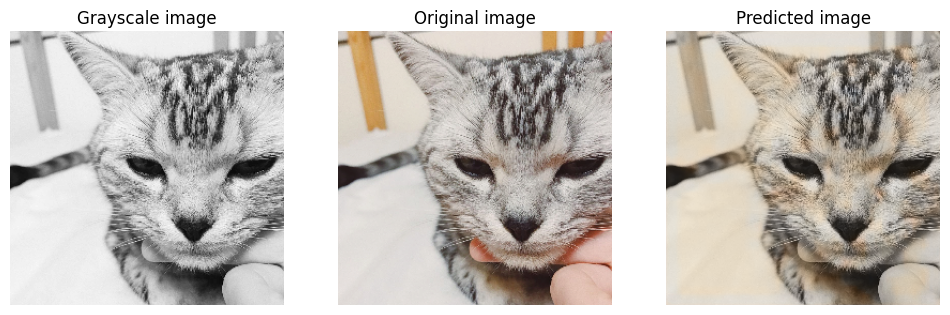

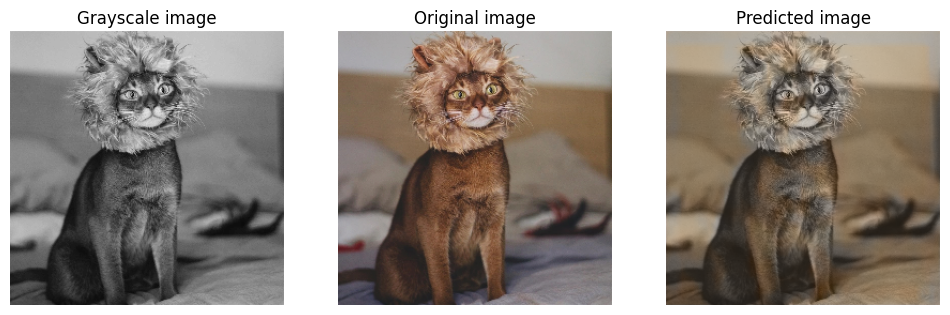

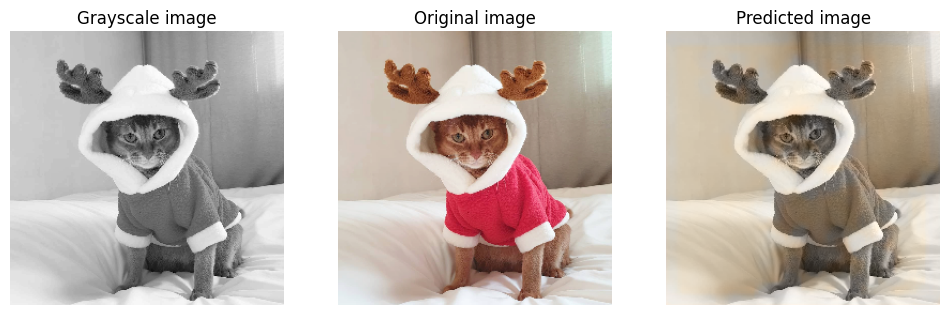

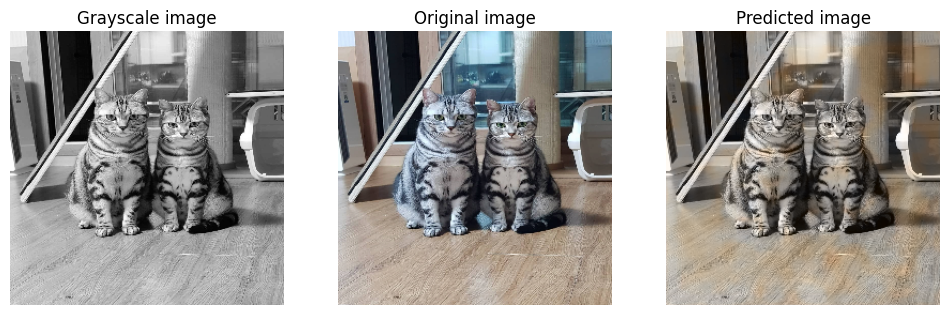

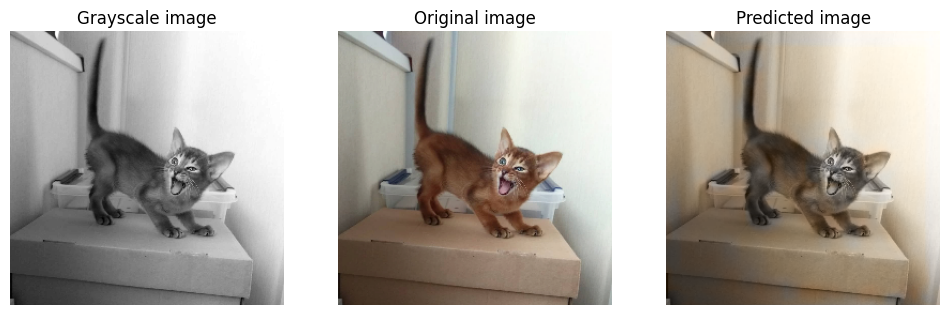

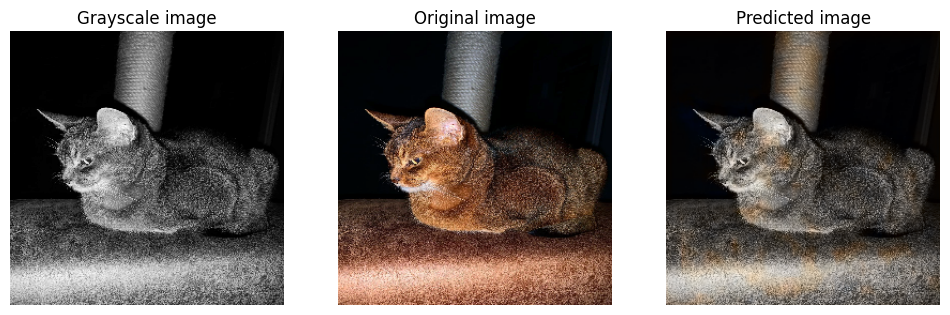

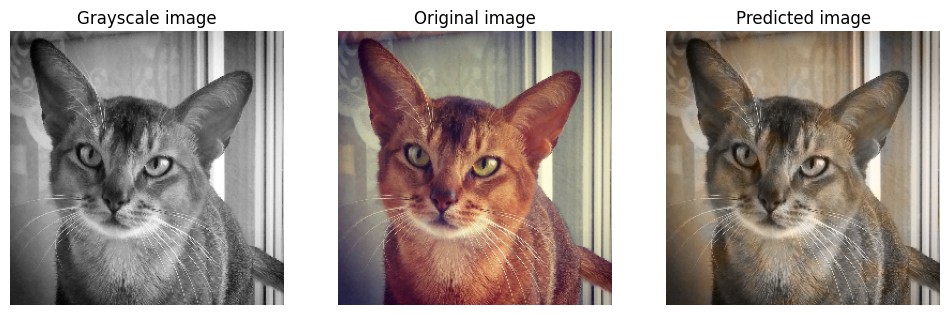

In [114]:
import matplotlib.pyplot as plt

max_veiw_samples = 10

x = x_test.copy()
y = y_test.copy()

# x = x_train.copy()
# y = y_train.copy()

predicts = model.predict(np.expand_dims(x,  axis=(3)))

for n, predict in enumerate(predicts):
  if n > max_veiw_samples: break
  grayscale = x[n].astype(np.uint8)
  pred_rgb = lab_in_rgb(x[n], predict*128)
  orig_rgb = lab_in_rgb(x[n], y[n])

  plt.figure(figsize=(12, 8))

  plt.subplot(1, 3, 1)
  plt.imshow(np.squeeze(grayscale), cmap='gray')
  plt.axis('off')
  plt.title('Grayscale image')

  plt.subplot(1, 3, 2)
  plt.imshow(orig_rgb)
  plt.axis('off')
  plt.title('Original image')

  plt.subplot(1, 3, 3)
  plt.imshow(pred_rgb)
  plt.axis('off')
  plt.title('Predicted image')

  plt.show()

### Сохраниение

In [ ]:
!git add alpha_version_notebook.ipynb

In [ ]:
!git commit -m "Добавил возможность рекурсивно загружать изображения для обучающей выборки из заданной п "

[alhpa-version 173023f] Добавил датасет изображений для обучения модели
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Alpha-version/alpha_version_notebook.ipynb (93%)


In [ ]:
!sh git_push.sh

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 4.73 KiB | 115.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/Evgev/Coloring-greyscale-images.git
   fb18f3d..173023f  alhpa-version -> alhpa-version
